In [51]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
import numpy as np
from arch import arch_model

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

## Load Data

We begin by loading the data from yfinance -- see the arma_model.ipynb for previous steps and details regarding loading stock data from yfinance in python. 

In [15]:
spy = yf.Ticker("SPY")
# hist = spy.history(period = "1y", interval= "1d")
hist = spy.history(start = "2010-01-04", end = "2020-02-01")
df = pd.DataFrame(hist, columns=['Close'])
df.head

<bound method NDFrame.head of                                 Close
Date                                 
2010-01-04 00:00:00-05:00   88.117912
2010-01-05 00:00:00-05:00   88.351151
2010-01-06 00:00:00-05:00   88.413368
2010-01-07 00:00:00-05:00   88.786591
2010-01-08 00:00:00-05:00   89.082047
...                               ...
2020-01-27 00:00:00-05:00  307.216400
2020-01-28 00:00:00-05:00  310.435791
2020-01-29 00:00:00-05:00  310.179352
2020-01-30 00:00:00-05:00  311.186005
2020-01-31 00:00:00-05:00  305.535461

[2537 rows x 1 columns]>

## Background

Previously, we concluded that the closing price of $SPY could be modeled adequately by a random walk model. The reasons for this will become inttuive once we take a brief but useful look at the efficient market hypothesis. 

### Efficient Market Hypothesis:

The efficient market hypothesis states that the price of a stock is reflective of an efficient market - thus all information about the company is reflected in the current value of the stock. Thus, there can be no arbitrage, an essentially riskless or minimally riskless profit-taking based on market ineffiicencies leading to a difference of a current stock value and its actual value. While this view is controversial, it is at the basis of a lot of economic theory. It does imply that consistently beating the market is impossible based on information about the price of a security up until time *t*, because all information is available publically through time *t*. 

This can be mathematically expressed in the following way: 

$E[X_t|X_{t-1}, X_{t-2}, \dots , X_{-\infty}] = 0$

where $X_t$ is the current asset price/return and we condition on all previous prices/returns $X_{-\infty: t-1}$


However, this should not be confused with implying that there is no way to make a profit. Recall, arbitrage reflects a riskless method to extract profit. However, there do exist investments which have considerably more risk and create opportunities for profit through risk. As a result, we can use the notion of risk and model adjacent terms such as volatitlity to make profits. 

### Volatility

Volatility and risk are closely related terms in financial assets such as stocks. In the stock market, volatility refers to the amount and frequency of price fluctuations. Risk, meanwhile, refers to the probability of losing money when investing in a particular stock.

We can connect the two - risk and volatility - by sticking with a general concept that the righer the volatility, the higher the risk of a financial asset. A simple illustration could be as follows: 

- Company A has a stock price of $100 which we are confident (ignore how this confidence is obtained for pragmantic purposes) will only move +/-5% in the next quarter. 
- Company B has a stock price of $100 which we are confident can move between +/- 50% in the next quarter. 

Albeit a very simplified example, we can see that with the added voltatility of company B there comes an added notion of risk with the asset.

### Volatility Clustering

We are able to capture volatility clustering -- pockets of time where volatility moves together, ie high volatility or low volatility time periods -- via modeling processes with ARCH. Thus, we can leverage these notions of risk and volatility in the hopes of making profits on assets while still abiding by the principles of the Efiicient Market Hypothesis which limits us to preoducing only trival responses to the conditional expected value of a stock at time *t* given previous observations. 

[include how volatility clustering is done via proof?]


### Returns

Let's take a small detour to mention the modeling of returns rather than prices. This is a convenient way to model stocks or other financial assets and as such will be important and simple to conceptualize: 

Let $R_t$ denote the retun of an asset at time *t*, $P_t$ denote the price of the asset at time *t*. Then we can formulate the simple one period return of an asset as follows: 

$R_t = \frac{P_t - P_{t-1}}{P_{t-1}}$ 

The log return which is often used is denoted by the following where $r_t$ is the log return: 

$r_t = log(\frac{P_t}{P_{t-1}}) = log P_t - log P_{t-1}$ 

In [16]:
# convert prices to returns 
df = df.pct_change()
df.head()

,Close
Date,
2010-01-04 00:00:00-05:00,NaN
2010-01-05 00:00:00-05:00,0.002647
2010-01-06 00:00:00-05:00,0.000704
2010-01-07 00:00:00-05:00,0.004221
2010-01-08 00:00:00-05:00,0.003328


## ARCH model 

### Motivation & Uses

We have mentioned previously that although we can not calculate the predicted price of a financial asset in the stock market due to the Efficient Market Hypothesis (EMH), we can predict volatility. Volatitlity is synonymous with a term, or symbol, we are familiar with in statistics, $\sigma^2$. 

The model we will use for this is called auto-regressive conditional heteroscedastic model of order p, ARCH(p). 

Lets unpack the terminology a bit, specifically the heterscedastic model. Recall, in various cases we want a homoskedastic model, that is one where there is constant variance across observations. You may recall this being shown in linear modeling and in the model capabilities of ARMA(p,q). However, in this case, we specify that there is actually heteroskedasticity and, thus, non-constant variance. This generally takes the form of increasing variance as time *t* goes to $\infty$. We are interested in modeling exactly this, how the variance changes over time *t*. 

### Model Statement

$X_t = \sigma_t\epsilon_t$ with $\sigma_t^2 = b_0 + \sum_{j=1}^{p} b_jX^2_{t-j}$, where $\epsilon_t$ is IID(0,1) and $b_0, b_1, \dots, b_p \ge 0$

We then have $X_t$, the price of an asset being modeled by the sum of its squared past values $X_{t-j}^2$. If we think of $X_t$ as the returns of an asset, then $X_t^2$ is the marginal variance of the returns. Why is this the case?

Recall the relationship between variance and expected value of $var(X) = E[X^2] - E[X]^2$ where we know that $E[X_t$] = 0 because of the EMH, ie that returns are 0 in the time series in expectation. Thus, $E[X_t]^2$ = 0. We are left with the marginal variance $\sigma^2 = E[X_t^2]$

This marginal variance is not what we are after though, it simply highlights a detail of the ARCH model that the marginal variance is constant and does not depend on t because of stationarity and the above. We want instead to model the volatility at time t ($\sigma_t^2$). This volatility is directily influenced by the squared return $X_t^2$ and is the conditional variance of the time series. 

We can use all of the above intuitively to see that if $X_t$ swings rapidly (the return increases or decreased swiftly), $X_t^2$ is high and thus the volatility $\sigma^2_t$ at time t is high. This is how price swings impact the volatility of an underlying asset and are modeled by ARCH effects.

A small note is that the effect of these large swings  and thus changes to $X_t^2$ diminish quickly with the current model structure. The math in this can be avoided at the moment, but we can sumamrize the effect of this by saying that if there is a large swing in asset prices h days prior, the effect of this swing will decay exponentially with larger h. 

## GARCH model 



### Model Statement

$X_t = \sigma_t\epsilon_t$ with $\sigma_t^2 = b_0 + \sum_{j=1}^{p} b_jX^2_{t-j} + \sum_{j=1}^{p} a_j\sigma^2_{t-j}$, where $\epsilon_t$ is IID(0,1) and $b_0, b_1, \dots, b_p, a_1, a_2 \dots, a_q \ne 0$


### Motivation & Uses

GARCH is the generalized auto-regressive conditional heteroscedastic model of order (p,q) and is an extension of the ARCH(p) model. We notice the additional term being shown above when defining the conditional variance, volatility $\sigma_t^2$ at time t, which allows for modeling of the conditional variance to be dependent on lagged versions of the conditional variance. That is previous values of conditional vvariance are allowed to impact the current conditional variance using a linear combination of $a_1, a_2, \dots, a_p$ and the conditional variances at previous times. This addition to the model statement makes GARCH models more flexible and able to capture the persistence of volatility.

We can thus reduce the model statement in the following way by decomposing the parts of the model into: 

1) ARCH effects, effects attributed to allowing for lagged squared returns $X_t^2$

2) GARCH effects, effects attributed to allowing for lagged conditional variances $\sigma^2_t$

### Exploratory Data Analysis (EDA)

We begin the EDA phase by plotting a trace plot of the returns over time. Some minor comments are that we can notice that there is volatility clustering in the returns over time -- notice that there are periods with more variance, illustrated by higher highs and lower lows, which group or cluster together and periods where we see less variation. 

Text(0.5, 1.0, 'Log returns of S&P 500')

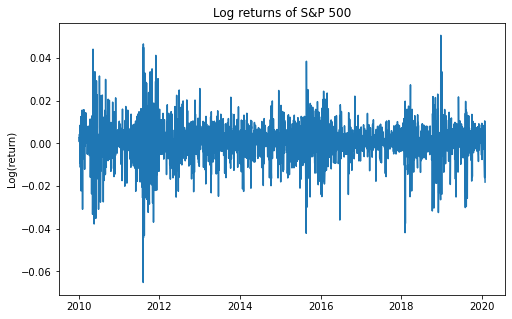

In [21]:
# add trace plot
plt.figure(figsize=(8,5))
plt.plot(df['Close'])
plt.ylabel("Log(return)")
plt.title('Log returns of S&P 500')

We then continue the EDA phase by running autocorrelation and partial autocorrelation plots to visualize how previous returns (different lags) are correlated with one another. Recall, that because of properties of stationarity, the correlation and covariance at different points in time should be the same for the same gap in time regardless of the point in time. That is, it shoudl be constant across the same gap in time and should depend only on the gap, *t-s* and not directly on *t*. As a result, we are able to construct the following plots based on different lagged values, h, and not dependent on the point in time t of the lag since they should persist for any starting point t in time. 

Note: as a result of using the log returns we lose the first data point since there is no intuitive way for the first point to have a return.

/Users/danielherrera/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


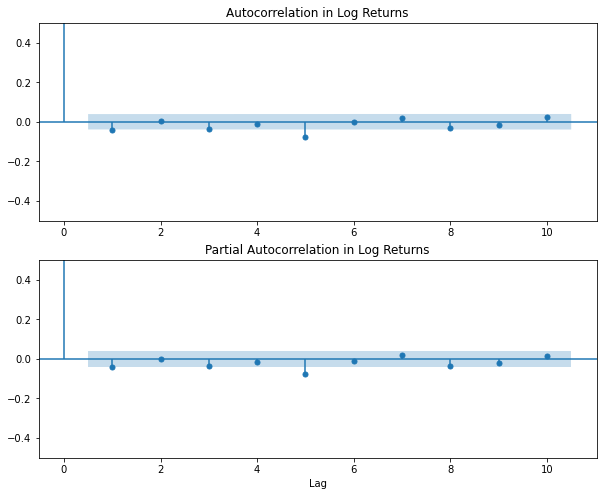

In [47]:
# Plot ACF and PACF
diff_ts = df['Close'][1:]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(diff_ts, ax=ax1, lags=10)
ax1.set_ylim(-0.5, .5) 
ax1.set_title("Autocorrelation in Log Returns")
plot_pacf(diff_ts, ax=ax2, lags=10)
ax2.set_ylim(-0.5, .5)  
ax2.set_xlabel("Lag")  
ax2.set_title("Partial Autocorrelation in Log Returns")

plt.show()

The above ACF and PACF plots are not indicative of the pattern that we would be interested in finding for the ACF or PACF to denote that there are ARCH and GARCH effects present. In particular, we would want to see that there are reasons why we believe the series in not independent and thus we can model the ARCH effects. 

To ensure that this is an independent series, or rather to test that it is not, we would remember that an independent series is one in which transformations of the series would themselves be independent. Thus, we can repeat the process above using the squared returns or the absolute returns. We will utilize the absolute returns, as this is generally utilized in financial data to diminsih the effects of outliers. 

/Users/danielherrera/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


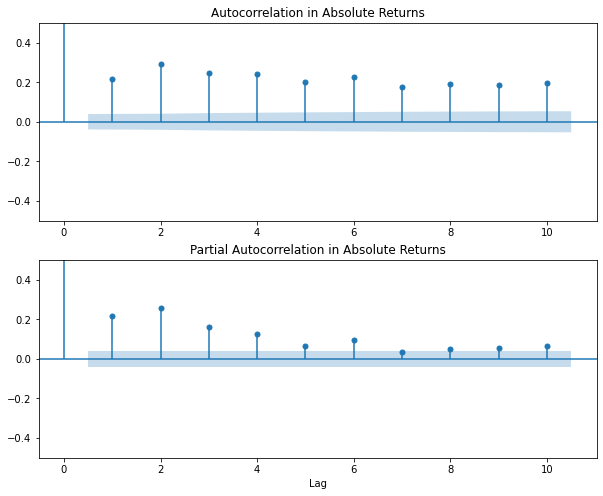

In [53]:
# Plot ACF and PACF of absolute returns
abs_returns = diff_ts.abs()
abs_returns.tail()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(abs_returns, ax=ax1, lags=10)
ax1.set_ylim(-.5, .5) 
ax1.set_title("Autocorrelation in Absolute Returns")
plot_pacf(abs_returns, ax=ax2, lags=10)
ax2.set_ylim(-.5, .5)  
ax2.set_title("Partial Autocorrelation in Absolute Returns")
ax2.set_xlabel("Lag")  
plt.show()

After the above transformation to absolute returns, we observe that there are ARCH effects that we can model as there are clear dependencies based on the correlations we see based on different lag values. We will more formally test these effects using the McLeod-Li test for ARCH and GARCH effects.  

### McLeod-Li Test

The McLeod-Li test proposes the following null and alternative hypotheses to test for white noise behavior in the residuals of the series: 

$H_0$:  there are no autoregressive conditional heteroscedasticity (ARCH) effects in the time series

$H_a$: there are ARCH effects in the time series

We thus first fit a model of GARCH(1,1) and then apply the McLeod-Li test to those residuals.

In [57]:
# fit model GARCH (1,1)
garch_mod = arch_model(abs_returns, vol='Garch', p=1, q=1)
res_garch = garch_mod.fit()

# Run the McLeod-Li test
mcleod_test = res_garch.mcleod_li()
print(mcleod_test.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 9042105910851.576
Iteration:      2,   Func. Count:     21,   Neg. LLF: 2.0890192035332972e+26
Iteration:      3,   Func. Count:     35,   Neg. LLF: 63212.01511805605
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 63212.016006581405
            Iterations: 3
            Function evaluations: 35
            Gradient evaluations: 3


/Users/danielherrera/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.502e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/danielherrera/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:756: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


AttributeError: 'ARCHModelResult' object has no attribute 'mcleod_li'

In [58]:
!pip show arch

Name: arch
Version: 5.4.0
Summary: ARCH for Python
Home-page: https://github.com/bashtage/arch
Author: Kevin Sheppard
Author-email: kevin.sheppard@economics.ox.ac.uk
License: NCSA
Location: /Users/danielherrera/opt/anaconda3/lib/python3.9/site-packages
Requires: pandas, statsmodels, property-cached, scipy, numpy
Required-by: 
